In [6]:
import stanfordnlp
from graphviz import Digraph

In [54]:
#stanfordnlp.download('ru') 

Using the default treebank "ru_syntagrus" for language "ru".
Would you like to download the models for: ru_syntagrus now? (Y/n)
Y

Default download directory: /home/alex/stanfordnlp_resources
Hit enter to continue or type an alternate directory.


Download location: /home/alex/stanfordnlp_resources/ru_syntagrus_models.zip


100%|██████████| 236M/236M [06:12<00:00, 677kB/s]  



Download complete.  Models saved to: /home/alex/stanfordnlp_resources/ru_syntagrus_models.zip
Extracting models file for: ru_syntagrus
Cleaning up...Done.


In [3]:
nlp = stanfordnlp.Pipeline(lang='ru')

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_tokenizer.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_tagger.pt', 'pretrain_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus.pretrain.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_lemmatizer.pt', 'lang': 'ru', 'shorthand': 'ru_syntagrus', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': '/home/alex/stanfordnlp_resources/ru_syntagrus_models/ru_syntagrus_parser.pt', 'p

In [56]:
doc = nlp("Рядом с красной современной машиной стоят два деревянных стула.")

In [57]:
def create_vis_graph(dep_tree):
    G = Digraph()
    for dep in dep_tree:
        if dep[2].upos != 'PUNCT':
            G.node(dep[2].index, dep[2].text)
    for dep in dep_tree:
        if dep[0].text != 'ROOT' and dep[2].upos != 'PUNCT':
            G.edge(dep[0].index, dep[2].index, label=dep[2].dependency_relation)
    return G

In [58]:
G = create_vis_graph(doc.sentences[0].dependencies)

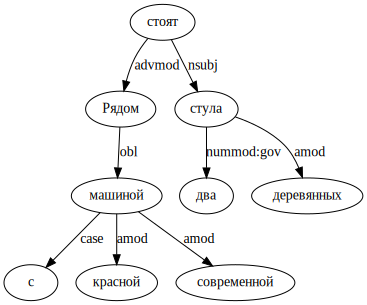

In [59]:
G